# Importing Libraries

In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib as mpl
import matplotlib.patches as mpatches 
from matplotlib.colors import LinearSegmentedColormap
from datetime import datetime

import re
import os
import MySQLdb
import warnings 
import missingno as ms


warnings.filterwarnings('ignore')
sns.set(style='whitegrid')
plt.style.use('Solarize_Light2')

# Data Preparation / Data Wrangling

connection server database

In [24]:
def connect_db():
    """Membuat koneksi ke database MySQL"""
    try:
        host = os.getenv("DB_HOST", "192.168.11.64")
        user = os.getenv("DB_USER", "mlite_dev")
        passwd = os.getenv("DB_PASS", "fdyYLSPtJzYJbdyk")
        db = os.getenv("DB_NAME", "mlite_dev")
        port = int(os.getenv("DB_PORT", 3306))
        # host = os.getenv("DB_HOST", "192.168.11.5")
        # user = os.getenv("DB_USER", "rsds_db")
        # passwd = os.getenv("DB_PASS", "rsdsD4t4b4s3")
        # db = os.getenv("DB_NAME", "rsds_db")
        # port = int(os.getenv("DB_PORT", 3306))
        # host = os.getenv("DB_HOST", "localhost")
        # user = os.getenv("DB_USER", "root")
        # passwd = os.getenv("DB_PASS", "")
        # db = os.getenv("DB_NAME", "sik")
        # port = int(os.getenv("DB_PORT", 3306))
        
        conn = MySQLdb.connect(
            host=host,
            user=user,
            passwd=passwd,
            db=db,
            port=port
        )
        print("Koneksi database berhasil!")
        return conn
        
    except Exception as e:
        print(f"Gagal terkoneksi ke database. Error: {str(e)}")
        raise

In [25]:
def get_data_from_db(query):
    """Mengambil data dari database dan mengembalikan DataFrame"""
    conn = None
    try:
        conn = connect_db()
        # query = "SELECT * FROM pasien;"
        df = pd.read_sql_query(query, conn)
        print("Data berhasil diambil!")
        return df
        
    except Exception as e:
        print(f"Gagal mengambil data. Error: {str(e)}")
        raise
        
    finally:
        if conn:
            conn.close()
            print("Koneksi database ditutup")

Deteksi nomor telepon pasien yang bernilai Null, Simbol, karakter non-digit dan panjang nomor

In [26]:
if __name__ == "__main__":
    # Definisikan query SQL
    query = "SELECT * FROM pasien"
    
    # Panggil fungsi dan simpan hasilnya ke variabel df
    df = get_data_from_db(query)
    
    # Sekarang Anda bisa akses kolom
    print("Kolom yang tersedia:")
    print(df.columns)
    
    # Contoh tampilkan 5 baris pertama
    print("\n5 data pertama:")
    print(df.head())

Koneksi database berhasil!
Data berhasil diambil!
Koneksi database ditutup
Kolom yang tersedia:
Index(['no_rkm_medis', 'nm_pasien', 'no_ktp', 'jk', 'tmp_lahir', 'tgl_lahir',
       'nm_ibu', 'alamat', 'gol_darah', 'pekerjaan', 'stts_nikah', 'agama',
       'tgl_daftar', 'no_tlp', 'umur', 'pnd', 'keluarga', 'namakeluarga',
       'kd_pj', 'no_peserta', 'kd_kel', 'kd_kec', 'kd_kab', 'pekerjaanpj',
       'alamatpj', 'kelurahanpj', 'kecamatanpj', 'kabupatenpj',
       'perusahaan_pasien', 'suku_bangsa', 'bahasa_pasien', 'cacat_fisik',
       'email', 'nip', 'kd_prop', 'propinsipj'],
      dtype='object')

5 data pertama:
  no_rkm_medis         nm_pasien            no_ktp jk tmp_lahir   tgl_lahir  \
0       000001  HAIRIAH BILLI,HJ            565778  P     Tapin  1942-01-01   
1       000002      Datu Sanggul         123456789  L     Tapin  1983-11-12   
2       000008        YUSDIANI,H  6305040505570003  L     Tapin  1957-05-05   
3       000011          ROKHANAH              8888  P     

In [27]:
df.describe(include='all').transpose().T.style.background_gradient(cmap="RdPu")

,no_rkm_medis,nm_pasien,no_ktp,jk,tmp_lahir,tgl_lahir,nm_ibu,alamat,gol_darah,pekerjaan,stts_nikah,agama,tgl_daftar,no_tlp,umur,pnd,keluarga,namakeluarga,kd_pj,no_peserta,kd_kel,kd_kec,kd_kab,pekerjaanpj,alamatpj,kelurahanpj,kecamatanpj,kabupatenpj,perusahaan_pasien,suku_bangsa,bahasa_pasien,cacat_fisik,email,nip,kd_prop,propinsipj
count,88419,88416,88416,88416,88419,88197,88419,88419,88419,88416,88419,88419,54868,88419,88419,88419,88419,88419,88419,88416,88419.000000,88419.000000,88419.000000,88419,88419,88419,88419,88419,88419,88419.000000,88419.000000,88419.000000,88419,88419,88419.000000,88419
unique,88419,64182,62709,3,6872,25087,10614,46056,6,331,6,14,1637,32827,23580,12,9,37870,18,42647,nan,nan,nan,491,24354,2544,1285,466,1,nan,nan,nan,78,59,nan,39
top,000001,ARBAINAH,0,L,Tapin,1957-07-01,-,Bitahan,-,-,MENIKAH,ISLAM,2024-08-26,080000000000,,-,,,A09,0,nan,nan,nan,-,ALAMAT,KELURAHAN,KECAMATAN,KABUPATEN,-,nan,nan,nan,-,0,nan,PROPINSI
freq,1,127,8481,44312,14713,167,70795,477,85252,42127,39038,54262,186,43658,32930,54710,33551,16902,51155,34469,nan,nan,nan,65193,46511,48269,47763,47748,88419,nan,nan,nan,72877,56821,nan,47732
mean,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,4528.539013,9380.745643,14963.648039,nan,nan,nan,nan,nan,nan,19.587170,15.564177,2.708818,nan,nan,161.024440,nan
std,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,15852.243692,73804.838470,21531.035568,nan,nan,nan,nan,nan,nan,0.960406,2.242534,1.978701,nan,nan,1649.651716,nan
min,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.000000,1.000000,1.000000,nan,nan,nan,nan,nan,nan,19.000000,12.000000,1.000000,nan,nan,1.000000,nan
25%,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.000000,1.000000,1.000000,nan,nan,nan,nan,nan,nan,19.000000,12.000000,1.000000,nan,nan,1.000000,nan
50%,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1388.000000,108.000000,241.000000,nan,nan,nan,nan,nan,nan,19.000000,17.000000,1.000000,nan,nan,63.000000,nan
75%,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1727.000000,512.000000,46828.000000,nan,nan,nan,nan,nan,nan,21.000000,17.000000,5.000000,nan,nan,63.000000,nan


Key Insights
1. Data Unik & Duplikasi:
    - Terdapat 89.218 record pasien, tetapi hanya ada:
        + 64.737 nama unik (≈72.6% duplikasi nama)
        + 63.489 nomor KTP unik (≈28.8% KTP duplikat/placeholder "0")
    - Indikasi kemungkinan data dummy atau kesalahan input pada kolom seperti no_ktp (8.463 entri "0") dan no_tlp (44.336 entri "080000000000").
2. Demografi Pasien:
    - Dominasi gender laki-laki (44.769 entri "L" vs perempuan ≈44.446)
    - Usia rata-rata pasien 19.59 tahun (SD 0.97), menunjukkan mayoritas pasien remaja akhir (19-21 tahun)
    - Tempat lahir terbanyak di Tapin (14.693 entri)
3. Data Administrasi:
    - Agama dominan Islam (55.138 entri)
    - Status pernikahan terbanyak "MENIKAH" (39.620 entri)
    - Kode pembayaran (kd_pj) terbanyak A09 (51.394 entri)
4. Anomali Data:
    - Tanggal registrasi (tgl_daftar) terbanyak 26 Agustus 2024 (tanggal masa depan)
    - Tempat lahir generik seperti "Bitahan" (477 entri) dan "ALAMAT" (47.8k entri di alamatpj)
    - Kode wilayah (kelurahan/kecamatan/kabupaten) menunjukkan pola tidak wajar:
        + 75% data kd_kec bernilai ≤512, tetapi nilai maksimal 716.506

In [28]:
# Cek duplikasi no_ktp
ktp_analysis = pd.DataFrame({
    'Total Data': [df['no_ktp'].count()],
    'Unique Values': [df['no_ktp'].nunique()],
    'Duplikat': [df['no_ktp'].duplicated().sum()],
    'Nilai Paling Umum': [df['no_ktp'].mode().values[0]],
    'Frekuensi Nilai Umum': [df['no_ktp'].value_counts().iloc[0]]
}).transpose().style.background_gradient(cmap="RdPu")

ktp_analysis

,0
Total Data,88416
Unique Values,62709
Duplikat,25709
Nilai Paling Umum,0
Frekuensi Nilai Umum,8481


<!-- 
 -->

In [29]:
# Filter data dengan pengecualian nama mengandung variasi "BY" atau "Bayi"
filter_pattern = r'\b(?:BY|By|by|Bayi|BAYI)\b'
filtered_data = df[~df['nm_pasien'].str.contains(filter_pattern, case=False, na=False)]

# Seleksi kolom dan cek duplikasi
selected_data = filtered_data[['no_rkm_medis', 'nm_pasien', 'no_ktp', 'kd_pj']]
duplicate_data = selected_data[selected_data.duplicated(subset=['no_ktp'], keep=False)]

# Sorting dan export ke CSV
duplicate_data.sort_values(by=['no_ktp', 'no_rkm_medis'], inplace=True)
duplicate_data.to_csv("data\data_duplikat_ktp_filtered.csv", index=False)

print(f"Jumlah data terfilter: {len(filtered_data)}")
print(f"Jumlah duplikat KTP yang terfilter: {len(duplicate_data)}")
print(f"File CSV berhasil dibuat: data_duplikat_ktp_filtered.csv")

Jumlah data terfilter: 84004
Jumlah duplikat KTP yang terfilter: 24557
File CSV berhasil dibuat: data_duplikat_ktp_filtered.csv


In [30]:
# Deteksi nomor yang mengandung karakter non-digit
invalid_format = df['no_tlp'].str.contains(r'[^0-9]', na=True, regex=True).sum()
print(f"Entries with non-numeric characters: {invalid_format}")

Entries with non-numeric characters: 0


count    88419.000000
mean        11.976939
std          0.293528
min         10.000000
25%         12.000000
50%         12.000000
75%         12.000000
max         24.000000
Name: no_tlp_length, dtype: float64


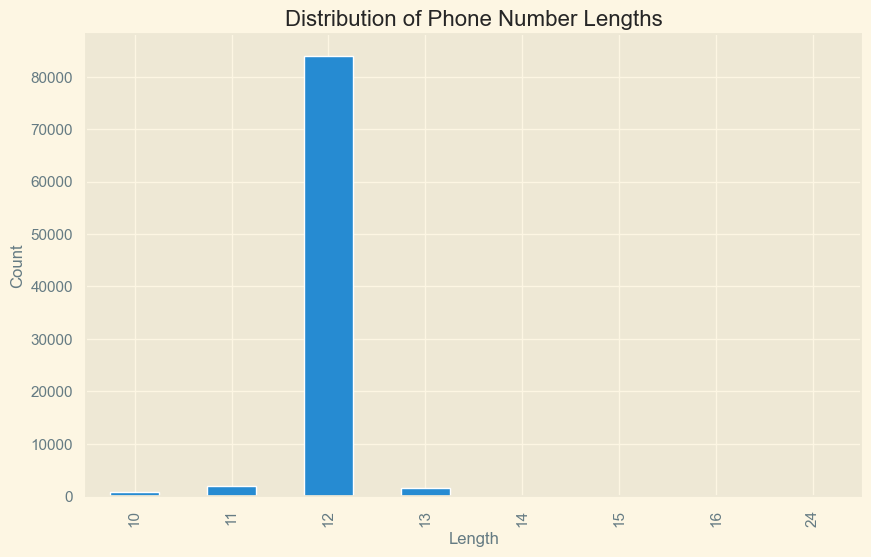

In [31]:
# Hitung panjang nomor telepon
df['no_tlp_length'] = df['no_tlp'].str.len()

# Statistik panjang nomor
length_stats = df['no_tlp_length'].describe()
print(length_stats)

# Visualisasi distribusi panjang
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
df['no_tlp_length'].value_counts().sort_index().plot(kind='bar')
plt.title("Distribution of Phone Number Lengths")
plt.xlabel("Length")
plt.ylabel("Count")
plt.show()

In [32]:
# Hitung nomor yang tidak diawali dengan '08'
invalid_prefix = (~df['no_tlp'].str.startswith('08', na=False)).sum()
print(f"Entries with invalid prefix: {invalid_prefix}")

Entries with invalid prefix: 0


In [33]:
# Hitung duplikat pada kolom no_tlp
duplicates = df['no_tlp'].duplicated().sum()
print(f"Duplicate Entries: {duplicates}")

# Contoh nilai yang sering duplikat
common_duplicates = df['no_tlp'].value_counts().head(10)
print("\nTop 10 Most Common Duplicates:")
print(common_duplicates)

Duplicate Entries: 55592

Top 10 Most Common Duplicates:
no_tlp
080000000000      43658
08000000000         702
0800000000          594
0800000000000       413
08000000000000       42
082255232484         37
085248000000         33
081348000000         32
085348263272         28
085248287151         25
Name: count, dtype: int64


In [34]:
def validate_ktp(no_ktp):
    """Validasi format nomor KTP:
    1. Harus 16 digit angka
    2. Tidak mengandung karakter non-digit
    3. Tidak boleh kosong"""
    if pd.isna(no_ktp) or no_ktp in ['', ' ']:
        return False
    no_ktp = str(no_ktp).strip()
    return len(no_ktp) <= 16 and no_ktp.isdigit()

In [35]:
def validate_nama(nama):
    """Validasi format nama:
    1. Minimal 2 karakter
    2. Tidak mengandung angka/simbol khusus
    3. Tidak boleh kosong
    4. Memfilter nama 'bayi', 'by', atau variasi kapitalisasi lainnya"""
    
    # Cek nilai kosong/NaN
    if pd.isna(nama) or str(nama).strip() in ['', ' ']:
        return False
    
    nama_clean = str(nama).strip()
    
    # Filter khusus untuk kata "bayi" dalam semua kapitalisasi
    forbidden_names = {'bayi', 'by'}  # Lowercase untuk case-insensitive check
    if nama_clean.lower() in forbidden_names:
        return False
    
    # Validasi karakter dan panjang
    return (
        len(nama_clean) >= 2 and 
        re.match(r"^[a-zA-Z\s'-]+$", nama_clean) is not None
    )

In [36]:
if __name__ == "__main__":
    # Definisikan query SQL
    query = "SELECT no_rkm_medis, nm_pasien, no_ktp, kd_pj FROM pasien WHERE kd_pj = 'bpj'"  # Ambil hanya kolom yang diperlukan
    
    # Panggil fungsi dan simpan hasilnya ke variabel df_ktp_bpj
    df_ktp_bpj = get_data_from_db(query)
    
    # Validasi data
    df_ktp_bpj['ktp_valid'] = df_ktp_bpj['no_ktp'].apply(validate_ktp)
    df_ktp_bpj['nama_valid'] = df_ktp_bpj['nm_pasien'].apply(validate_nama)
    
    # Analisis hasil
    total_invalid_ktp = (~df_ktp_bpj['ktp_valid']).sum()
    total_invalid_nama = (~df_ktp_bpj['nama_valid']).sum()
    
    # Tampilkan hasil
    print(f"\n[Laporan Validasi Data BPJ]")
    print("====================================")
    print(f"\nTotal Data: {len(df_ktp_bpj)}")
    print(f"KTP Tidak Valid: {total_invalid_ktp} ({total_invalid_ktp/len(df_ktp_bpj)*100:.2f}%)")
    print(f"Nama Tidak Valid: {total_invalid_nama} ({total_invalid_nama/len(df_ktp_bpj)*100:.2f}%)")

Koneksi database berhasil!
Data berhasil diambil!
Koneksi database ditutup

[Laporan Validasi Data BPJ]

Total Data: 36741
KTP Tidak Valid: 1207 (3.29%)
Nama Tidak Valid: 14702 (40.02%)


In [37]:
# Contoh data tidak valid
print("\nContoh Data Tidak Valid:")
invalid_samples = df_ktp_bpj[~df_ktp_bpj['ktp_valid'] | ~df_ktp_bpj['nama_valid']].sample(10)
print(invalid_samples[['nm_pasien', 'no_ktp']])


Contoh Data Tidak Valid:
                nm_pasien            no_ktp
36582      SAGIRAH.Hj, Ny  6305034603560001
22631          BAINAH, NY  6305074107710014
34911       RAHMAH, By.Ny                 -
34439      NURLIYANTI, Ny  6303106111930003
28632         BUDIMAN, Tn  6305111311010002
8553          PARIYEM, Ny  6310077009870001
28856   JIBRAN JUNIOR, An  6305012411170002
21835  SITI NURHALIZA, Nn  6305045007010002
29427          YUNANI, Tn  6305042805660001
35628      AHMAD YANI, Tn  6305031709680002


In [38]:
    # Breakdown masalah KTP
    ktp_issues = df_ktp_bpj[~df_ktp_bpj['ktp_valid']]
    ktp_problems = {
        'Panjang Salah': ktp_issues['no_ktp'].apply(lambda x: len(str(x)) != 16 if pd.notna(x) else False).sum(),
        'Mengandung Non-Digit': ktp_issues['no_ktp'].str.contains(r'\D', na=True).sum(),
        'Kosong/NULL': ktp_issues['no_ktp'].isna().sum() + (ktp_issues['no_ktp'] == '').sum()
    }
    
    print("\nBreakdown Masalah KTP:")
    for issue, count in ktp_problems.items():
        print(f"{issue}: {count}")


Breakdown Masalah KTP:
Panjang Salah: 1204
Mengandung Non-Digit: 1196
Kosong/NULL: 3


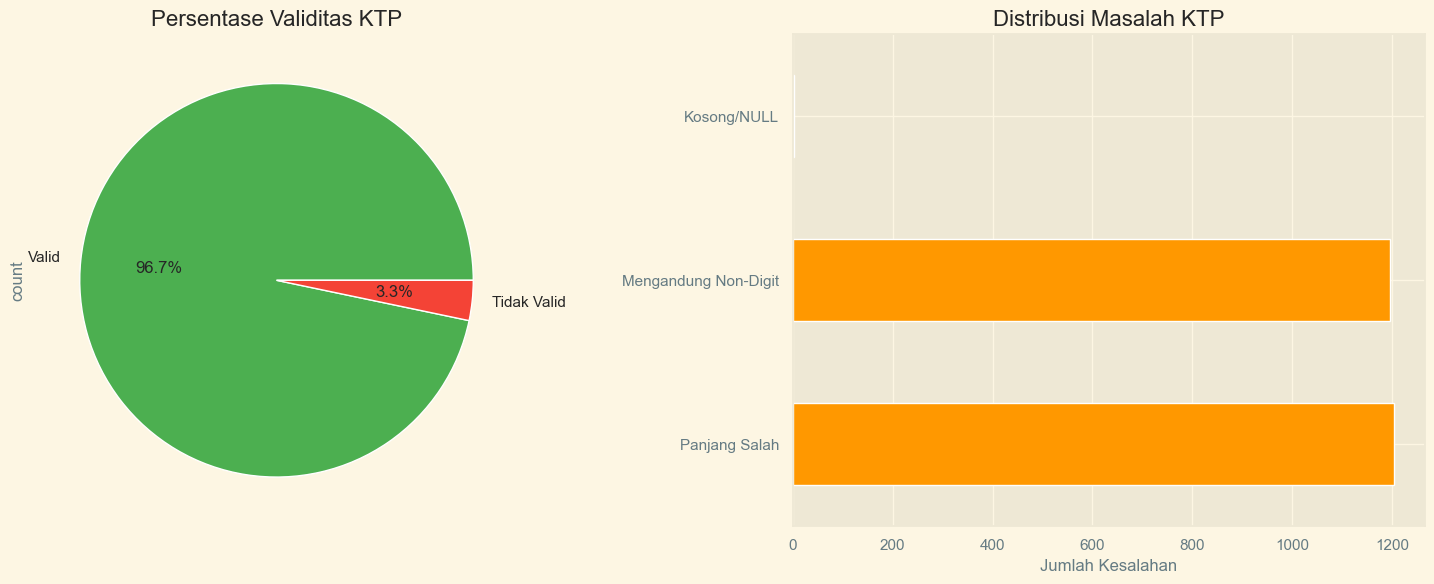

In [39]:
# Visualisasi
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Pie chart validitas KTP
df_ktp_bpj['ktp_valid'].value_counts().plot.pie(
    autopct='%1.1f%%',
    labels=['Valid', 'Tidak Valid'],
    colors=['#4CAF50', '#F44336'],
    ax=ax[0]
)
ax[0].set_title('Persentase Validitas KTP')

# Bar chart masalah KTP
pd.Series(ktp_problems).plot.barh(ax=ax[1], color='#FF9800')
ax[1].set_title('Distribusi Masalah KTP')
ax[1].set_xlabel('Jumlah Kesalahan')

plt.tight_layout()
plt.show()

In [40]:
# Simpan data tidak valid ke file
df_ktp_bpj[~df_ktp_bpj['ktp_valid']].to_csv('data/ktp_tidak_valid.csv', index=False)
df_ktp_bpj[~df_ktp_bpj['nama_valid']].to_csv('data/nama_tidak_valid.csv', index=False)

In [41]:
if __name__ == '__main__':

    current_date = datetime.today().strftime('%Y-%m-%d')
    start_date = current_date
    end_date = current_date

    # Definisikan query SQL
    # Query tetap sama
    query = f"""
    SELECT 
        rp.no_rawat,
        rp.tgl_registrasi,
        rp.jam_reg,
        rp.kd_dokter,
        d.nm_dokter,
        rp.no_rkm_medis,
        pas.nm_pasien,
        rp.kd_poli,
        p.nm_poli,
        rp.status_lanjut,
        rp.kd_pj,
        pj.png_jawab,
        mar.tanggal_periksa,
        mar.nomor_kartu,
        mar.nomor_referensi,
        mar.kodebooking,
        mar.jenis_kunjungan,
        mar.status_kirim,
        mar.keterangan,
        bs.user
    FROM 
        reg_periksa rp
    JOIN 
        mlite_antrian_referensi mar ON rp.no_rkm_medis = mar.no_rkm_medis
    JOIN 
        poliklinik p ON rp.kd_poli = p.kd_poli
    JOIN 
        dokter d ON rp.kd_dokter = d.kd_dokter
    JOIN 
        penjab pj ON rp.kd_pj = pj.kd_pj
    JOIN 
        pasien pas ON rp.no_rkm_medis = pas.no_rkm_medis
    JOIN
        bridging_sep bs ON rp.no_rawat = bs.no_rawat
    WHERE
        rp.tgl_registrasi BETWEEN '{start_date}' AND '{end_date}'
        AND mar.tanggal_periksa BETWEEN '{start_date}' AND '{end_date}'
        AND rp.kd_poli NOT IN ('IGDK', 'HDL', 'BBL', 'IRM')
        AND rp.status_lanjut NOT IN ('Ranap')
    ORDER BY rp.no_rawat;
    """
    
    # Panggil fungsi dan simpan hasilnya ke variabel df
    df = get_data_from_db(query)

    # df = df.drop_duplicates()

    # Export ke CSV
    # Buat nama file dengan tanggal
    filename = f'data_antrian_{start_date}_hingga_{end_date}.csv'
    
    # Simpan ke CSV tanpa index
    df.to_csv(filename, index=False)
    
    print(f"Data berhasil disimpan ke file: {filename}")

Koneksi database berhasil!
Data berhasil diambil!
Koneksi database ditutup
Data berhasil disimpan ke file: data_antrian_2025-03-05_hingga_2025-03-05.csv
